# 가위바위보 분류기

* 이미지 분류 모델을 만들어 가위바위보를 각각 분류하기

* 평가 문항
    * 이미지 분류기 모델이 성공적으로 만들어졌는가?
    * 오버피팅을 극복하기 위한 적절한 시도가 있었는가?
    * 분류모델의 test accuracy가 기준 이상 높게 나왔는가?

### 1. 데이터 불러오기와 resize
(이미지 제작: https://teachablemachine.withgoogle.com/)
* 이미지 조작을 위해 PIL 라이브러리 사용
* 이미지를 28x28 사이즈로 변환

In [1]:
from PIL import Image
import glob
import os

In [2]:
def resize_image(img_path):
    images = glob.glob(img_path + '/*.jpg')
    
    print(len(images), 'images to be resized...')
    
    target_size = (28, 28)
    
    for img in images:
        old_img = Image.open(img)
        new_img = old_img.resize(target_size, Image.ANTIALIAS)
        new_img.save(img, 'JPEG')
        
    print(len(images), 'images resized.')
    print('\n')

#가위 이미지 resize
image_dir_path_scissor = os.getenv('HOME') + '/aiffel/rock_scissor_paper/scissor'
resize_image(image_dir_path_scissor)

#바위 이미지 resize
image_dir_path_rock = os.getenv('HOME') + '/aiffel/rock_scissor_paper/rock'
resize_image(image_dir_path_rock)

#보 이미지 resize
image_dir_path_paper = os.getenv('HOME') + '/aiffel/rock_scissor_paper/paper'
resize_image(image_dir_path_paper)

print('가위 바위 보 이미지 resize 완료')

1501 images to be resized...
1501 images resized.


1501 images to be resized...
1501 images resized.


1501 images to be resized...
1501 images resized.


가위 바위 보 이미지 resize 완료


* **알게된 것**

    * **glob.glob():** 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환한다
   
    * **Image.ANTIALIAS:** 높은 해상도의 사진 또는 영상을 낮은 해상도로 변환하거나 나타낼 때 깨진 패턴의 형태로 나타나게 되는데 이를 최소화 시켜준다.

### 2. load_data() 함수
* 데이터를 읽을 수 있는 함수 만들기
* 입력으로 이미지가 있는 폴더 위치를 받고 각각의 클래스로 라벨링 한다.

In [3]:
import numpy as np

def load_data(img_path, number_of_data=4503): #number_of_data에 데이터 총 개수를 입력한다.
    img_size = 28
    color = 3    
    
    # 이미지 데이터와 라벨(가위:0, 바위:1, 보:2) 데이터를 담을 행렬 생성
    imgs = np.zeros(number_of_data*img_size*img_size*color, dtype = np.int32).reshape(number_of_data, img_size, img_size, color)
    labels = np.zeros(number_of_data, dtype = np.int32)
    
    idx = 0
    
    for file in glob.glob(img_path + '/scissor/*.jpg'):
        img = np.array(Image.open(file), dtype = np.int32)
        imgs[idx, :, :, :] = img    #데이터 영역에 이미지 행렬을 복사
        labels[idx] = 0   #가위 : 0
        idx += 1
        
    for file in glob.glob(img_path + '/rock/*.jpg'):
        img = np.array(Image.open(file), dtype = np.int32)
        imgs[idx, :, :, :] = img
        labels[idx] = 1    #바위 : 1
        idx += 1
        
    for file in glob.glob(img_path + '/paper/*.jpg'):
        img = np.array(Image.open(file), dtype = np.int32)
        imgs[idx, :, :, :] = img
        labels[idx] = 2   #보 : 2
        idx += 1
        
    print("학습 데이터 (x_train)의 이미지 개수는 ", idx, "입니다.")
    return imgs, labels


image_dir_path = os.getenv('HOME') + "/aiffel/rock_scissor_paper"
(x_train, y_train) = load_data(image_dir_path)
x_train_norm = x_train/255.0    #입력을 0~1 사이의 값으로 정규화

print('x_train shape: {}'.format(x_train.shape))
print('y_train shape: {}'.format(y_train.shape))
        

학습 데이터 (x_train)의 이미지 개수는  4503 입니다.
x_train shape: (4503, 28, 28, 3)
y_train shape: (4503,)


* **알게된 것**

    * **라벨이란:** 원본 데이터에 대한 추가적인 정보가 포함된 '마커', 중요한 것은 데이터가 아닌 점이다.
        * 반려동물 이미지에서 강아지는 강아지, 고양이는 고양이로 지정하는 등
    * **color=3인 이유:** rgb값이라서
    
    * **int32:** numpy의 ndarray(다차원 행렬 구조)는 dtype으로 저장되는데, int32는 numpy의 주요 데이터형 중 하나이다. (https://engineer-mole.tistory.com/85)
    
    * **255.0을 나누는 이유:** 인공지능 모델을 훈련시키고 사용할 때, 일반적으로 입력은 0에서1 사이의 값으로 정규화 시켜주는 것이 좋은데, 각 픽셀의 값이 0~255 사이 범위에 있기 때문에 255.0으로 나누어준다
    
    * **x_train, y_train으로 데이터를 나누는 이유:** train 데이터를 train 데이터와 validation 데이터로 나누는 용도
        * 학습은 보통 train데이터와 validation데이터로 이루어지고, 학습이 완료되면 test 데이터를 사용한다.
        (https://lsjsj92.tistory.com/545)

라벨:  0


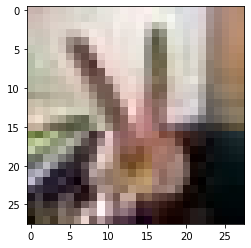

In [4]:
import matplotlib.pyplot as plt

plt.imshow(x_train[0])
print('라벨: ', y_train[0])

### 3. 딥러닝 네트워크 설계하기

In [5]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.layers import Dropout

# 파라미터

n_channel_1=32
n_channel_2=32
n_channel_3=64
n_dense=512
n_train_epoch=15

model=keras.models.Sequential()

model.add(keras.layers.Conv2D(n_channel_1, (3,3),  activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(1,1))


model.add(keras.layers.Conv2D(n_channel_2, (3,3),  activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))


model.add(keras.layers.Conv2D(n_channel_3, (3,3),  activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Conv2D(n_channel_3, (3,3),  activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Flatten())
model.add(Dropout(0.5))
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(Dropout(0.5))
model.add(keras.layers.Dense(3, activation='softmax'))


'''
model = keras.Sequential()

model.add(keras.layers.Conv2D(n_channel_1, (3, 3),  activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(1,1))


model.add(keras.layers.Conv2D(n_channel_2, (3, 3),  activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))


model.add(keras.layers.Conv2D(n_channel_3, (3, 3),  activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))


model.add(keras.layers.Flatten())
model.add(Dropout(0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(keras.layers.Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(keras.layers.Dense(units=3, activation = 'softmax'))
'''

#모델 요약
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          3

* **알게된 것:**
    * **sequentialAPI:** 간단하게 딥러닝 모델을 만들 수 있는 방법으로, 미리 정의된 딥러닝 레이어를 쉽게 추가할 수 있다. 단, 개발의 자유도는 많이 떨어진다.
    * **convolution(conv2D):** convolution이란 convolution layer의 크기 만큼 이동시키면서 겹쳐지는 부분의 각 원소의 값을 곱해서 모두 더한 값을 출력하는 층이다. 이미지를 인식시킬 때, 주변 값들의 관계를 알아내기 위해서 적용한다.
    * **MaxPooling**: Pooling은 차례로 처리되는 데이터의 크기를 줄이는 것을 말하고, MaxPooling은 해당 영역에서 최댓값을 찾는 방법이다.
        * AveragePooling은 해당 영역에서 평균값을 계산하는 방법이다.
        * pooling을 하는 이유: **차원을 감소시키기 위해!!** 왜냐면, 더 높은 정확도를 위해서는 필터가 많아야 함. 필터가 많아지면,
            * Feature Map 늘어나서 안좋음 -> dimension이 늘어남 -> 파라미터의 수가 늘어난다
                * 오버피팅 문제, 모델 사이즈와 레이턴시에도 영향을 미침 -> 차원을 감소시킬 필요성
        (https://underflow101.tistory.com/41)
        
    * **activation 함수:** 비선형 시스템으로 만들기 위해(인공지능 관련 AND, OR, XOR 참고)
    (https://ganghee-lee.tistory.com/30)
        

* **LeNet?**
    * 이번 exploration에서 사용한 모델이 LeNet이라는 걸 알았는데, 합성곱 신경망을 활용하는 LeNet은 LeNet-1에서 LeNet-5까지 개발되었다.
    (https://www.hellot.net/mobile/article.html?no=42920)

### 4. 딥러닝 네트워크 학습시키기

In [6]:
# 모델 훈련
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, y_train, epochs=n_train_epoch)

Epoch 1/15
141/141 [==============================] - 4s 5ms/step - loss: 0.9525 - accuracy: 0.6904
Epoch 2/15
141/141 [==============================] - 1s 4ms/step - loss: 0.0434 - accuracy: 0.9845
Epoch 3/15
141/141 [==============================] - 1s 4ms/step - loss: 0.0340 - accuracy: 0.9878
Epoch 4/15
141/141 [==============================] - 1s 4ms/step - loss: 0.0190 - accuracy: 0.9916
Epoch 5/15
141/141 [==============================] - 1s 4ms/step - loss: 0.0087 - accuracy: 0.9978
Epoch 6/15
141/141 [==============================] - 1s 4ms/step - loss: 0.0071 - accuracy: 0.9978
Epoch 7/15
141/141 [==============================] - 1s 4ms/step - loss: 0.0021 - accuracy: 0.9996
Epoch 8/15
141/141 [==============================] - 1s 4ms/step - loss: 0.0030 - accuracy: 0.9987
Epoch 9/15
141/141 [==============================] - 1s 4ms/step - loss: 0.0071 - accuracy: 0.9980
Epoch 10/15
141/141 [==============================] - 1s 4ms/step - loss: 0.0621 - accuracy: 0.9876

* **알게된 것**
    * **optimizer:** 손실함수의 결과값을 최소화하는 모델의 파라미터(가중치)를 찾는 것 (https://blog.naver.com/another0430/222063836606)
    * **손실함수(loss):** 데이터를 토대로 산출한 모델의 예측 값과 실제 값의 차이를 표현하는 지표
    * **평가지표(metric):** 검증셋에서 훈련된 모델의 성능을 평가할 때 어떤 평가지표로 평가할지를 결정
    (https://bskyvision.com/740)

### 5. 테스트

In [7]:
def resize_image(img_path):
    images = glob.glob(img_path + '/*.jpg')
    
    print(len(images), 'images to be resized...')
    
    target_size = (28, 28)
    
    for img in images:
        old_img = Image.open(img)
        new_img = old_img.resize(target_size, Image.ANTIALIAS)
        new_img.save(img, 'JPEG')
        
    print(len(images), 'images resized.')
    print('\n')

#가위 이미지 resize
image_dir_path_scissor = os.getenv('HOME') + '/aiffel/rock_scissor_paper/test/scissor'
resize_image(image_dir_path_scissor)

#바위 이미지 resize
image_dir_path_rock = os.getenv('HOME') + '/aiffel/rock_scissor_paper/test/rock'
resize_image(image_dir_path_rock)

#보 이미지 resize
image_dir_path_paper = os.getenv('HOME') + '/aiffel/rock_scissor_paper/test/paper'
resize_image(image_dir_path_paper)

print('가위 바위 보 테스트 이미지 resize 완료')

201 images to be resized...
201 images resized.


201 images to be resized...
201 images resized.


202 images to be resized...
202 images resized.


가위 바위 보 테스트 이미지 resize 완료


In [9]:
import numpy as np

def load_data(img_path, number_of_data=604): #number_of_data에 데이터 총 개수를 입력한다.
    img_size = 28
    color = 3    
    
    # 이미지 데이터와 라벨(가위:0, 바위:1, 보:2) 데이터를 담을 행렬 생성
    imgs = np.zeros(number_of_data*img_size*img_size*color, dtype = np.int32).reshape(number_of_data, img_size, img_size, color)
    labels = np.zeros(number_of_data, dtype = np.int32)
    
    idx = 0
    
    for file in glob.glob(img_path + '/scissor/*.jpg'):
        img = np.array(Image.open(file), dtype = np.int32)
        imgs[idx, :, :, :] = img    #데이터 영역에 이미지 행렬을 복사
        labels[idx] = 0   #가위 : 0
        idx += 1
        
    for file in glob.glob(img_path + '/rock/*.jpg'):
        img = np.array(Image.open(file), dtype = np.int32)
        imgs[idx, :, :, :] = img
        labels[idx] = 1    #바위 : 1
        idx += 1
        
    for file in glob.glob(img_path + '/paper/*.jpg'):
        img = np.array(Image.open(file), dtype = np.int32)
        imgs[idx, :, :, :] = img
        labels[idx] = 2   #보 : 2
        idx += 1
        
    print("테스트 데이터 (x_test)의 이미지 개수는 ", idx, "입니다.")
    return imgs, labels


image_dir_path = os.getenv('HOME') + "/aiffel/rock_scissor_paper/test"
(x_test, y_test) = load_data(image_dir_path)
x_test_norm = x_train/255.0    #입력을 0~1 사이의 값으로 정규화

print('x_test shape: {}'.format(x_test.shape))
print('y_test shape: {}'.format(y_test.shape))

테스트 데이터 (x_test)의 이미지 개수는  604 입니다.
x_test shape: (604, 28, 28, 3)
y_test shape: (604,)


In [10]:
test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

19/19 - 0s - loss: 9.1442 - accuracy: 0.6507
test_loss: 9.144172668457031 
test_accuracy: 0.6506622433662415


* **정확도를 올리기 위해** (0.3444 - 0.5695 - 0.4636 ...-0.6507
    * **데이터셋 늘리기:** 동기분들 데이터셋 활용 -> 이후 직접 찍은 이미지들로만 재구성
    * **하이퍼 파라미터 값 바꾸기**
    * **Dropout 추가해보기:** 오버피팅을 방지
    * **다양한 모델 layer 구성 변경 시도:** conv2d와 pooling layer를 추가
    * **데이터셋 재구성:** 확실하게 구별 가능한 이미지로 재구성, 테스트 데이터셋 확인
    * **LeNet-5 적용 시도:** 이미지 resize를 (32, 32)로 늘린 후 모델에 입력해봤으나 모델 layer 구성 자체가 LeNet-1과 크게 다르지 않아서인지 정확도에는 큰 변화가 보이지 않았다.(제대로 LeNet-5를 구현했는지는 모르겠음. 더 공부해봐야 알 것 같다.)


    

* **느낀점**
    * **하이퍼 파라미터를 높게 잡아준다고 무조건 좋은 것은 아니다.** 특징을 많이 찾아내더라도 유의미한 특징만을 찾을 거라는 보장이 없다. 파라미터 각각의 의미에 대해 조금 더 공부해볼 필요성을 느끼게 되었다.
    
    * **데이터셋의 볼륨이 큰 것이 높은 정확도로 가는 지름길은 아니다.** 과적합의 위험도 있고 지금 당장 dropdout이나 과적합을 피하기 위한 방법에 대한 지식이 충분하지 않아서 활용을 제대로 못하고 있는 느낌을 받았다. 모델을 구성하는 레이어와 레이어에 인자들의 의미를 이해하고 조절한다면 조금이라도 더 높은 정확도를 도출할 수 있을 것 같다.
    
    * **분류 모델 중 LeNet에 대해 조금 더 알게 되었다.** 1단계부터 5단계까지 발전해온 것을 알았고, 이미지 사이즈가 커지면 학습 시간이 오래 걸리지만 이 점이 정확도에 큰 연관이 있는지는 조금 더 공부해야 확실히 이해할 것 같다. 아직은 LeNet-1과 LeNet-5의 차이점 중 이미지 사이즈 크기 외에는 내가 이해할 수 있는 범위가 아니어서 이 역시 조금 더 공부한 후에 다시 읽어봐야할 것 같다.